In [66]:
# Reinforcement Learning Problem 1
# Oscar Eriksson, 0011301991, oscer@kth.se
# Philip Ahrendt, 960605R119, pcah@kth.se
import numpy as np
from matplotlib import pyplot as plt

In [67]:
MINOTAUR_CAN_STAY = False

""" underlying map -- cant move oob or itw """
_w = -10000
_g = 0
_f = -1
m = np.array([
    [ _f, _f, _w, _f, _f, _f, _f, _f, ],
    [ _f, _f, _w, _f, _f, _w, _f, _f, ],
    [ _f, _f, _w, _f, _f, _w, _w, _w, ],
    [ _f, _f, _w, _f, _f, _w, _f, _f, ],
    [ _f, _f, _f, _f, _f, _f, _f, _f, ],
    [ _f, _w, _w, _w, _w, _w, _w, _f, ],
    [ _f, _f, _f, _f, _w, _g, _f, _f, ],
]).T
w = m == _w
nw = m != _w
g = m == _g
ng = m != _g
f = m == _f
nf = m != _f

""" states, actions """
W = 8
H = 7
S = W*H*W*H
A = 5
UP, DOWN, LEFT, RIGHT, STAY = 0, 1, 2, 3, 4

""" utilities """
p_x_c = np.arange(W).reshape((W, 1, 1, 1, 1, 1, 1, 1, 1))
p_y_c = np.arange(H).reshape((1, H, 1, 1, 1, 1, 1, 1, 1))
m_x_c = np.arange(W).reshape((1, 1, W, 1, 1, 1, 1, 1, 1))
m_y_c = np.arange(H).reshape((1, 1, 1, H, 1, 1, 1, 1, 1))
a_c   = np.arange(A).reshape((1, 1, 1, 1, A, 1, 1, 1, 1))
p_x_n = np.arange(W).reshape((1, 1, 1, 1, 1, W, 1, 1, 1))
p_y_n = np.arange(H).reshape((1, 1, 1, 1, 1, 1, H, 1, 1))
m_x_n = np.arange(W).reshape((1, 1, 1, 1, 1, 1, 1, W, 1))
m_y_n = np.arange(H).reshape((1, 1, 1, 1, 1, 1, 1, 1, H))

""" Probability of player movements given actions (1 if feasible) """
P_p = np.zeros((W, H, A, W, H))
P_p[p_x_c, p_y_c, UP, p_x_n, p_y_n]    = (p_x_c == p_x_n) * (p_y_c - 1 == p_y_n) * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, DOWN, p_x_n, p_y_n]  = (p_x_c == p_x_n) * (p_y_c + 1 == p_y_n) * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, LEFT, p_x_n, p_y_n]  = (p_x_c + 1 == p_x_n) * (p_y_c == p_y_n) * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, RIGHT, p_x_n, p_y_n] = (p_x_c - 1 == p_x_n) * (p_y_c == p_y_n) * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, STAY, p_x_n, p_y_n]  = (p_x_c == p_x_n) * (p_y_c == p_y_n)

""" Probability of minotaur movements (1 over amount of feasible actions)"""
_P_m = np.zeros((W, H, A, W, H))
_P_m[m_x_c, m_y_c, UP, m_x_n, m_y_n]    = (m_x_c == m_x_n) * (m_y_c - 1 == m_y_n)
_P_m[m_x_c, m_y_c, DOWN, m_x_n, m_y_n]  = (m_x_c == m_x_n) * (m_y_c + 1 == m_y_n)
_P_m[m_x_c, m_y_c, LEFT, m_x_n, m_y_n]  = (m_x_c + 1 == m_x_n) * (m_y_c == m_y_n)
_P_m[m_x_c, m_y_c, RIGHT, m_x_n, m_y_n] = (m_x_c - 1 == m_x_n) * (m_y_c == m_y_n)
if MINOTAUR_CAN_STAY:
    _P_m[m_x_c, m_y_c, STAY, m_x_n, m_y_n] = (m_x_c == m_x_n) * (m_y_c == m_y_n)
P_m = np.sum(_P_m, axis=2)
P_m = P_m / np.maximum(np.sum(P_m, axis=(2,3), keepdims=True), 1)

"""
    a)
If we move simultaneously, then we may switch places with the minotaur without losing.
We of course still lose if we choose to move onto it.
"""
SIMULTANEOUS = True
if SIMULTANEOUS:
    """ make probability """
    # P(p_t,m_t,a_t,p_t+1,m_t+1) = P_p(p_t,a_t,p_t+1) * P_m(m_t,m_t+1)
    P = P_p[p_x_c, p_y_c, a_c, p_x_n, p_y_n] * P_m[m_x_c, m_y_c, m_x_n, m_y_n]
    # minotaur may catch
    P[p_x_c, p_y_c, p_x_c, p_y_c, :, :, :, :, :] = 0
    P[p_x_c, p_y_c, p_x_c, p_y_c, :, p_x_c, p_y_c, p_x_c, p_y_c] = 1

    """ make reward """
    R = np.zeros((W, H, W, H, A, W, H, W, H))
    # R = -1 if p_{t+1} != goal
    R[p_x_c, p_y_c, m_x_c, m_y_c, a_c, p_x_n, p_y_n, m_x_n, m_y_n] = -1 * (0.5 > g[p_x_n, p_y_n] * (p_x_n != m_x_n) * (p_y_n != m_y_n) * P_p[p_x_c, p_y_c, a_c, p_x_n, p_y_n])
    R = R.reshape((S, A, S))
    R = np.max(R, axis=2)

    P = P.reshape((S, A, S))

"""
    b)
If we move sequentially, we say that the minotaur can catch us in our current location as well, if we let it move first.
We of course still lose if we choose to move onto it.
Everything else is the same
""" 

""" flatten to move to state space """
s0 = np.arange((W*H*W*H)).reshape((W, H, W, H))[0, 0, 5, 6]

In [68]:
# let unused/inaccessible states self-loop
is_zero = (np.sum(P, axis=2) == 0)
for s, a in zip(*np.where(is_zero)):
    P[s, a, s] = 1

# we now prove that it is a markov decision process
assert np.allclose(np.sum(P, axis=2), 1)

In [69]:
def plot_policy(policy, m):
    plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
    for x in range(W):
        for y in range(H):
            s = np.ravel_multi_index((x, y, *m), (W, H, W, H))
            if f[x, y]:
                if policy[s] == UP: plt.arrow(x, y, 0, -0.5, color='r', width=0.1)
                if policy[s] == DOWN: plt.arrow(x, y, 0, 0.5, color='r', width=0.1)
                if policy[s] == RIGHT: plt.arrow(x, y, -0.5, 0, color='r', width=0.1)
                if policy[s] == LEFT: plt.arrow(x, y, 0.5, 0, color='r', width=0.1)
    plt.plot(*m, 'go', markersize=20)

def plot_policy_ax(ax, policy, m):
    ax.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
    for x in range(W):
        for y in range(H):
            s = np.ravel_multi_index((x, y, *m), (W, H, W, H))
            if f[x, y]:
                if policy[s] == UP: ax.arrow(x, y, 0, -0.5, color='r', width=0.1)
                if policy[s] == DOWN: ax.arrow(x, y, 0, 0.5, color='r', width=0.1)
                if policy[s] == RIGHT: ax.arrow(x, y, -0.5, 0, color='r', width=0.1)
                if policy[s] == LEFT: ax.arrow(x, y, 0.5, 0, color='r', width=0.1)
    ax.plot(*m, 'go', markersize=10)

True


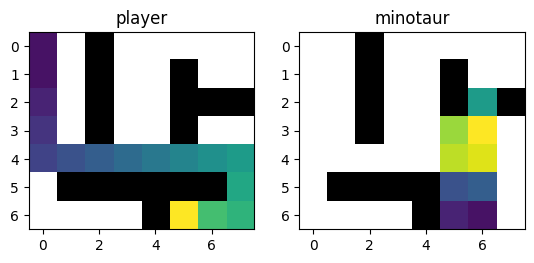

In [70]:
"""
    c)
We solve the dynamics programming problem by iterating backwards in time, with T=20.
We instrumentalize the simulation with maps keeping track of us and the minotaur
"""
T = 20
def DP(
        T: int, # horizon
    ) -> (
        np.ndarray((T+1, S)), # value
        np.ndarray((T, S)), # policy
    ):
    value = np.zeros((T+1, S))
    policy = np.zeros((T, S), dtype=np.int32)

    value[-1] = np.max(R, axis=1)
    for t in range(T-1,-1,-1):
        Q = R + P @ value[t+1]
        value[t] = np.max(Q, axis=1)
        policy[t] = np.argmax(Q, axis=1)
    return value, policy

def simulate_DP(
        T: int, # horizon
        policy: np.ndarray((T, S)),
    ) -> (
        bool, # did escape
        np.ndarray((W,H)), # time of every player position
        np.ndarray((W,H)), # time of every minotaur position
    ):
    s = s0
    map_p = np.zeros((W,H))
    map_m = np.zeros((W,H))
    p_x, p_y, m_x, m_y = np.unravel_index(s, (W, H, W, H))
    map_p[p_x, p_y] = 1
    map_m[m_x, m_y] = 1

    for t in range(T):
        p = P[s, policy[t, s]] # probabilities of possible next states

        s = np.random.choice(np.arange(S), p=p) # select next state
        p_x, p_y, m_x, m_y = np.unravel_index(s, (W, H, W, H))
        map_p[p_x, p_y] = t + 1
        map_m[m_x, m_y] = t + 1

    return (g[p_x, p_y] and ng[m_x, m_y]), map_p, map_m

def VI(
        gamma: float, # discount factor
    ) -> (
        np.ndarray((S,)), # value
        np.ndarray((S,)), # policy
    ):
    value = np.zeros((S,))
    policy = np.zeros((S,), dtype=np.int32)

    for _ in range(100):
        Q = R + gamma * P @ value
        value = np.max(Q, axis=1)
    policy = np.argmax(Q, axis=1)
    return value, policy

def simulate_VI(
        policy: np.ndarray((S,)),
        p_end: float = 0,
    ) -> (
        bool, # did escape
        np.ndarray((W,H)), # time of every player position
        np.ndarray((W,H)), # time of every minotaur position
    ):
    t = 1
    s = s0
    map_p = np.zeros((W,H))
    map_m = np.zeros((W,H))
    p_x, p_y, m_x, m_y = np.unravel_index(s, (W, H, W, H))
    map_p[p_x, p_y] = t
    map_m[m_x, m_y] = t

    while True:
        p = P[s, policy[s]] # probabilities of possible next states

        s = np.random.choice(np.arange(S), p=p) # select next state
        t += 1
        p_x, p_y, m_x, m_y = np.unravel_index(s, (W, H, W, H))
        map_p[p_x, p_y] = t
        map_m[m_x, m_y] = t

        if (p_x, p_y) == (m_x, m_y):
            break
        if g[p_x, p_y] and ng[m_x, m_y]:
            break
        if np.random.uniform() < p_end:
            break

    return (g[p_x, p_y] and ng[m_x, m_y]), map_p, map_m

T = 20
value, policy = DP(T)
escaped, map_p, map_m = simulate_DP(T, policy)
print(escaped)

ax1, ax2 = plt.subplot(121), plt.subplot(122)
ax1.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
ax1.imshow(map_p.T, alpha=(map_p > 0).T.astype(np.float32))
ax1.title.set_text('player')
ax2.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
ax2.imshow(map_m.T, alpha=(map_m > 0).T.astype(np.float32))
ax2.title.set_text('minotaur')
plt.plot()

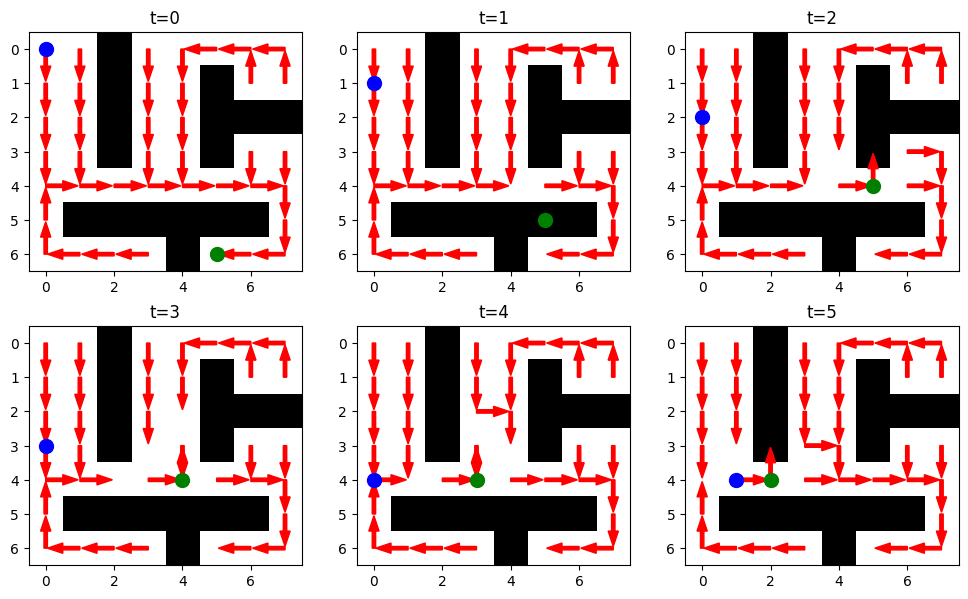

In [71]:
ax11, ax12, ax13, ax21, ax22, ax23 = plt.subplot(231), plt.subplot(232), plt.subplot(233), plt.subplot(234), plt.subplot(235), plt.subplot(236)
ax11.title.set_text('t=0')
ax11.plot(0, 0, 'bo', markersize=10)
plot_policy_ax(ax11, policy[0], (5, 6))
ax12.title.set_text('t=1')
ax12.plot(0, 1, 'bo', markersize=10)
plot_policy_ax(ax12, policy[1], (5, 5))
ax13.title.set_text('t=2')
ax13.plot(0, 2, 'bo', markersize=10)
plot_policy_ax(ax13, policy[2], (5, 4))
ax21.title.set_text('t=3')
ax21.plot(0, 3, 'bo', markersize=10)
plot_policy_ax(ax21, policy[3], (4, 4))
ax22.title.set_text('t=4')
ax22.plot(0, 4, 'bo', markersize=10)
plot_policy_ax(ax22, policy[4], (3, 4))
ax23.title.set_text('t=5')
ax23.plot(1, 4, 'bo', markersize=10)
plot_policy_ax(ax23, policy[5], (2, 4))
plt.gcf().set_size_inches(12, 7)
plt.plot()

In [72]:
"""
    d)
it appears that the minotaur is always unable to catch us
"""
s_c = np.arange((S)).reshape((-1, 1))
s_n = np.arange((S)).reshape((1, -1))
p_x_c = np.arange(W).reshape((-1, 1, 1, 1))
p_y_c = np.arange(H).reshape((1, -1, 1, 1))
m_x_c = np.arange(W).reshape((1, 1, -1, 1))
m_y_c = np.arange(H).reshape((1, 1, 1, -1))

prob = np.zeros((30, S))
Pi = np.zeros((30,))
for T in range(1,30):
    value, policy = DP(T)
    prob[T, s0] = 1

    for t in range(T):
        prob[T] = prob[T] @ P[s_c, policy[t, s_c], s_n]
    pi = np.sum(prob[T].reshape((W, H, W, H)), axis=(2,3))
    Pi[T] = pi[5, 6]
    print(T, pi[5, 6])
T = 30

1 0.0
2 0.0


3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.9999999999999998
16 0.9999999999999996
17 0.9999999999999996
18 0.9999999999999997
19 0.9999999999999998
20 0.9999999999999996
21 0.9999999999999996
22 0.9999999999999996
23 0.9999999999999996
24 0.9999999999999994
25 0.9999999999999996
26 0.9999999999999996
27 0.9999999999999996
28 0.9999999999999996
29 0.9999999999999996


Text(0, 0.5, 'P(escape)')

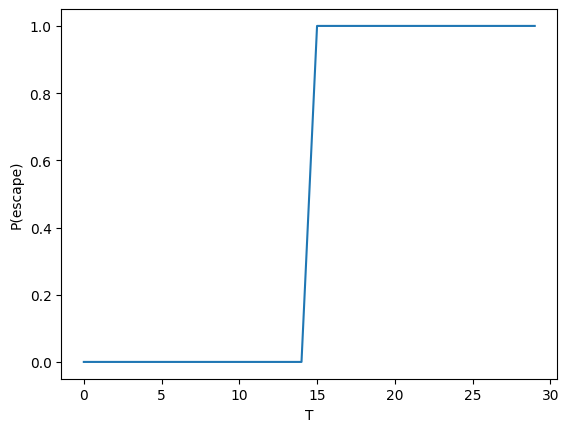

In [73]:
plt.plot(Pi)
plt.xlabel('T')
plt.ylabel('P(escape)')
plt.plot()

In [77]:
"""
    e)
simply train VI with gamma = 1 - 1 / 30
let simulation have a 1 / 30 chance of ending
"""
value, policy = VI(1 - 1 / 30)

"""
    f)
Simply simulate
"""
N = 10000
k = 0
for _ in range(N):
    escaped, map_p, map_m = simulate_VI(policy, 1 / 30)
    if escaped: k += 1
print(k / N)

0.6221


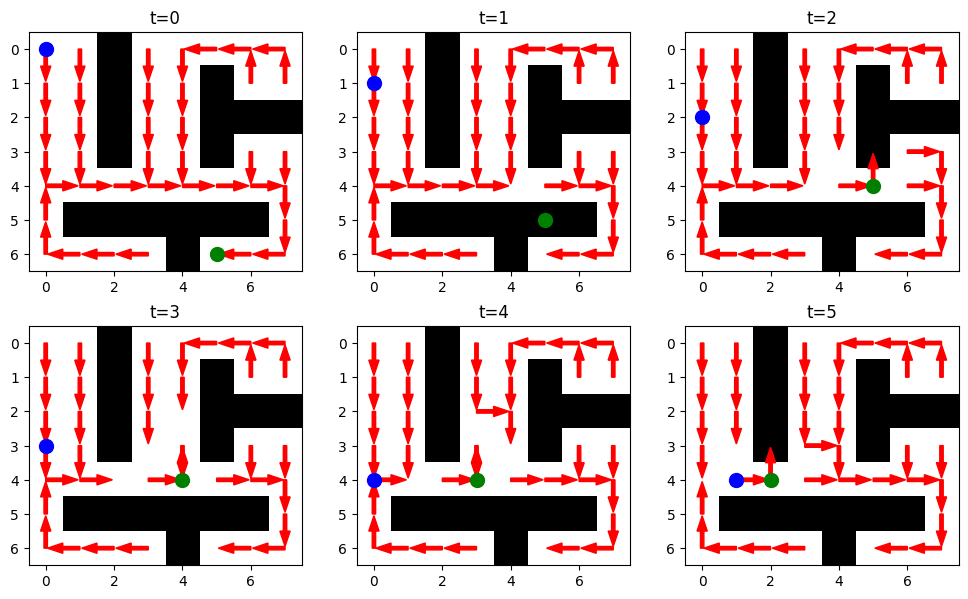

In [75]:
ax11, ax12, ax13, ax21, ax22, ax23 = plt.subplot(231), plt.subplot(232), plt.subplot(233), plt.subplot(234), plt.subplot(235), plt.subplot(236)
ax11.title.set_text('t=0')
ax11.plot(0, 0, 'bo', markersize=10)
plot_policy_ax(ax11, policy, (5, 6))
ax12.title.set_text('t=1')
ax12.plot(0, 1, 'bo', markersize=10)
plot_policy_ax(ax12, policy, (5, 5))
ax13.title.set_text('t=2')
ax13.plot(0, 2, 'bo', markersize=10)
plot_policy_ax(ax13, policy, (5, 4))
ax21.title.set_text('t=3')
ax21.plot(0, 3, 'bo', markersize=10)
plot_policy_ax(ax21, policy, (4, 4))
ax22.title.set_text('t=4')
ax22.plot(0, 4, 'bo', markersize=10)
plot_policy_ax(ax22, policy, (3, 4))
ax23.title.set_text('t=5')
ax23.plot(1, 4, 'bo', markersize=10)
plot_policy_ax(ax23, policy, (2, 4))
plt.gcf().set_size_inches(12, 7)
plt.plot()

In [76]:
"""
    g)
1) On policy is when one may observe the minotaur's actions and react to them. Off policy is when one may not
2) Both Q-learning and SARSA are fixed point iterations of the bellman equation, and thus converge to the optimal policy
This is true given that 1 >= lambda_i(P) >= 0, for all i (eigenvalues), and gamma < 1
"""

"""
    h)
let gamma = 1 - 1 / 50, double the amount of states such that one half corresponds to having the key and one half corresponds to not having the key
P_m_new = 0.65 P_m + 0.35 * T_{towards_you}, everything else remains the same!
"""

'\n    h)\nlet gamma = 1 - 1 / 50, double the amount of states such that one half corresponds to having the key and one half corresponds to not having the key\nP_m_new = 0.65 P_m + 0.35 * T_{towards_you}, everything else remains the same!\n'

In [ ]:
"""
    We did not attempt Q-learning/SARSA in this environment
"""